<h1 align="center">
Предсказание риска сердечного приступа у пациентов
</h1>

<br>

Мы получили тренировочную и тестовую выборку с данными пациентов.

Цели исследования:
1. Найти лучшую модель для эффективного предсказания сердечного приступа.
2. Разработать внешний интерфейс для взаимодействия с моделью.

Ход исследования:
1. Предобработка данных.
2. Исследовательский и корреляционный анализ.
2. Обучение и выбор наилучшей модели с помощью метрик.
3. Написание инструмента на FastAPI для тестирования.

## Загрузка данных

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
import shap
from sklearn.utils import resample
from joblib import dump, load

In [2]:
pth = './heart_train.csv'

if os.path.exists(pth):
    heart_train = pd.read_csv('heart_train.csv')
    heart_test = pd.read_csv('heart_test.csv')
else:
    heart_train = pd.read_csv('/datasets/heart_train.csv')
    heart_test = pd.read_csv('/datasets/heart_test.csv')

In [3]:
#смотрим на heart_train
pd.set_option('display.max_columns', None)
heart_train.head()

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,1,1.0,0.0,8.0,0.225704,0.105948,0.459176,0.979221,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,2,1.0,0.0,9.0,0.289923,0.164217,0.117053,0.515584,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,2,1.0,1.0,6.0,0.550133,0.598745,0.373574,0.012987,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,0,0.0,1.0,3.0,0.330962,0.077605,0.049735,0.131169,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,1,0.0,0.0,8.0,0.524600,0.341960,0.830405,0.070130,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047


In [4]:
# .info() не отображает все колонки, выведем информацию таблицей

def df_info(df):
    df_info = pd.DataFrame({
        'column': df.columns,
        'non_null': [df[col].notna().sum() for col in df.columns],
        'dtype': [df[col].dtype for col in df.columns]
    })

    return df_info

df_info(heart_train)

,column,non_null,dtype
0,Unnamed: 0,8685,int64
1,Age,8685,float64
2,Cholesterol,8685,float64
3,Heart rate,8685,float64
4,Diabetes,8442,float64
5,Family History,8442,float64
6,Smoking,8442,float64
7,Obesity,8442,float64
8,Alcohol Consumption,8442,float64
9,Exercise Hours Per Week,8685,float64


In [5]:
#смотрим heart_test
heart_test.head()

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.494382,0.264286,0.062328,0.0,1.0,1.0,1.0,1.0,0.361618,2,0.0,0.0,8.0,0.194370,0.587759,0.283490,0.306494,1.0,0.333333,0.227018,0.048229,0.036512,Male,0.283871,0.372093,7746
1,1,0.224719,0.953571,0.082493,1.0,0.0,0.0,1.0,0.0,0.996483,2,1.0,1.0,5.0,0.329888,0.602883,0.467036,0.087013,0.0,0.166667,0.227018,0.048229,0.036512,Female,0.703226,0.441860,4202
2,2,0.629213,0.092857,0.064161,0.0,1.0,1.0,1.0,0.0,0.995561,0,0.0,0.0,10.0,0.780075,0.370436,0.409366,0.205195,7.0,1.000000,0.102767,0.002666,0.088455,Male,0.458065,0.779070,6632
3,3,0.460674,0.567857,0.055912,1.0,1.0,1.0,1.0,1.0,0.437277,0,0.0,0.0,10.0,0.785071,0.368242,0.910261,0.163636,0.0,0.666667,0.203557,0.056390,0.271774,Female,0.741935,0.255814,4639
4,4,0.719101,0.485714,0.022915,1.0,0.0,1.0,0.0,1.0,0.514920,0,0.0,0.0,7.0,0.070919,0.729578,0.758924,0.580519,5.0,0.000000,0.227018,0.048229,0.036512,Male,0.412903,0.395349,4825


In [6]:
df_info(heart_test)

,column,non_null,dtype
0,Unnamed: 0,966,int64
1,Age,966,float64
2,Cholesterol,966,float64
3,Heart rate,966,float64
4,Diabetes,935,float64
5,Family History,935,float64
6,Smoking,935,float64
7,Obesity,935,float64
8,Alcohol Consumption,935,float64
9,Exercise Hours Per Week,966,float64


**Промежуточный вывод:** 

Получены датасеты с 25 входными признаками:
+ Age - возраст пациента
+ Cholesterol - уровень холестерина в крови
+ Heart rate - пульс
+ Diabetes - диабет (бинарный)
+ Family History - сердечно-сосудистые заболевания у родственников (бинарный)
+ Smoking - курение (бинарный)
+ Obesity - ожирение (бинарный)
+ Alcohol Consumption - употребление алкоголя (бинарный)
+ Exercise Hours Per Week - сколько часов в неделю человек занимается спортом
+ Diet - тип диеты (дискретный)
+ Previous Heart Problems - были ли ранее сердечные заболевания (бинарный)
+ Medication Use - принимает ли человек лекарства (бинарный)
+ Stress Level - уровень стресса (дискретный)
+ Sedentary Hours Per Day - часов сидячей активности в день
+ Income - доход
+ BMI - индекс массы тела
+ Triglycerides - уровень триглицеридов в крови
+ Physical Activity Days Per Week - число дней с физнагрузкой в неделю (дискретный)
+ Sleep Hours Per Day - часов сна в сутки
+ Blood sugar - уровень сахара в крови
+ CK-MB - фракция креатинкиназы, один из важных маркеров инфаркта
+ Troponin - уровень тропонина в крови, один из важных маркеров инфаркта
+ Gender - пол (бинарный)
+ Systolic blood pressure - систолическое давление
+ Diastolic blood pressure - диастолическое давление

Целевой признак:
+ Heart Attack Risk (Binary) - бинарный признак: высокий риск инфаркта / нет

Присутствуют пропуски в некоторых столбцах, значения признаков масштабированы.

## Предобработка данных

In [7]:
#приведем столбцы к общепринятому стилю

def good_cols(df):
    df.columns = df.columns.str.lower().str.replace(' ', '_')

good_cols(heart_train)
good_cols(heart_test)

In [8]:
#удалим лишний столбец

heart_train = heart_train.drop(columns='unnamed:_0')
heart_test = heart_test.drop(columns='unnamed:_0')

In [9]:
heart_train.head()

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_(binary),blood_sugar,ck-mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,1,1.0,0.0,8.0,0.225704,0.105948,0.459176,0.979221,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,2,1.0,0.0,9.0,0.289923,0.164217,0.117053,0.515584,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,2,1.0,1.0,6.0,0.550133,0.598745,0.373574,0.012987,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,0,0.0,1.0,3.0,0.330962,0.077605,0.049735,0.131169,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,1,0.0,0.0,8.0,0.524600,0.341960,0.830405,0.070130,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047


In [10]:
#создадим списки дискретных и непрерывных признаков

discrete_cols = ['diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption', 'diet',
                 'previous_heart_problems', 'medication_use', 'stress_level', 'physical_activity_days_per_week',
                 'gender', 'heart_attack_risk_(binary)']

continuous_cols = ['age', 'cholesterol', 'heart_rate', 'exercise_hours_per_week', 'sedentary_hours_per_day',
                   'income', 'bmi', 'triglycerides', 'sleep_hours_per_day', 'blood_sugar', 'ck-mb', 'troponin',
                   'systolic_blood_pressure', 'diastolic_blood_pressure']

In [11]:
#посмотрим уникальные значения категориальных признаков в heart_train

for col in discrete_cols:
    print(f"{col}: {sorted(heart_train[col].unique())}")

diabetes: [0.0, 1.0, nan]
family_history: [0.0, 1.0, nan]
smoking: [0.0, 1.0, nan]
obesity: [0.0, 1.0, nan]
alcohol_consumption: [0.0, 1.0, nan]
diet: [0, 1, 2, 3]
previous_heart_problems: [0.0, 1.0, nan]
medication_use: [0.0, 1.0, nan]
stress_level: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, nan]
physical_activity_days_per_week: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, nan]
gender: ['0.0', '1.0', 'Female', 'Male']
heart_attack_risk_(binary): [0.0, 1.0]


In [12]:
#удалим 0 и 1 из колонки gender (останется NaN)
heart_train['gender'] = heart_train['gender'].apply(lambda x: x if x in ['Male', 'Female'] else np.nan)

In [13]:
#подозреваем, что sleep_hours_per_day может быть дискретным признаком, смотрим уникальные значения
sorted(heart_train['sleep_hours_per_day'].unique())

[0.0,
 0.1666666666666666,
 0.3333333333333333,
 0.4999999999999999,
 0.5046212363584658,
 0.6666666666666666,
 0.8333333333333334,
 1.0]

In [14]:
#изменим количество значений у признака sleep_hours_per_day (будет 7 уникальных значений)

heart_train['sleep_hours_per_day'] = ((heart_train['sleep_hours_per_day'] / (1 / 6)
                                       ).round() * (1 / 6)
                                       ).round(2)
sorted(heart_train['sleep_hours_per_day'].unique())

[0.0, 0.17, 0.33, 0.5, 0.67, 0.83, 1.0]

In [15]:
#проверим датасет на пропуски
heart_train.isna().sum()

age                                  0
cholesterol                          0
heart_rate                           0
diabetes                           243
family_history                     243
smoking                            243
obesity                            243
alcohol_consumption                243
exercise_hours_per_week              0
diet                                 0
previous_heart_problems            243
medication_use                     243
stress_level                       243
sedentary_hours_per_day              0
income                               0
bmi                                  0
triglycerides                        0
physical_activity_days_per_week    243
sleep_hours_per_day                  0
heart_attack_risk_(binary)           0
blood_sugar                          0
ck-mb                                0
troponin                             0
gender                             243
systolic_blood_pressure              0
diastolic_blood_pressure 

In [16]:
#заменим пропуски в дискретных признаках модой
heart_train[discrete_cols] = heart_train[discrete_cols].fillna(heart_train[discrete_cols].mode().iloc[0])

In [17]:
print(f'Пропусков в data_train: {heart_train.isna().sum().sum()}')

Пропусков в data_train: 0


In [18]:
print(f'Строк-дубликатов в heart_train: {heart_train.duplicated().sum()}')

Строк-дубликатов в heart_train: 0


In [19]:
#назначим id индексом
heart_train = heart_train.set_index('id')

In [20]:
#исправим тип данных с float на int в дискретных признаках

for col in discrete_cols:
    if col != 'gender':
        heart_train[col] = heart_train[col].astype(int)

In [21]:
heart_train.head()

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_(binary),blood_sugar,ck-mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure
id,,,,,,,,,,,,,,,,,,,,,,,,,,
2664,0.359551,0.732143,0.074244,1,1,1,1,1,0.535505,1,1,0,8,0.225704,0.105948,0.459176,0.979221,3,0.33,0,0.227018,0.048229,0.036512,Male,0.212903,0.709302
9287,0.202247,0.325000,0.047663,1,1,0,0,1,0.068690,2,1,0,9,0.289923,0.164217,0.117053,0.515584,3,0.83,0,0.150198,0.017616,0.000194,Female,0.412903,0.569767
5379,0.606742,0.860714,0.055912,1,0,1,1,1,0.944001,2,1,1,6,0.550133,0.598745,0.373574,0.012987,2,1.00,0,0.227018,0.048229,0.036512,Female,0.238710,0.220930
8222,0.730337,0.007143,0.053162,0,0,1,0,1,0.697023,0,0,1,3,0.330962,0.077605,0.049735,0.131169,0,0.33,1,0.227018,0.048229,0.036512,Female,0.348387,0.267442
4047,0.775281,0.757143,0.021998,0,0,1,0,1,0.412878,1,0,0,8,0.524600,0.341960,0.830405,0.070130,5,1.00,1,0.227018,0.048229,0.036512,Male,0.619355,0.441860


In [22]:
#добавим sleep_hours_per_day в дискретные признаки

discrete_cols.append('sleep_hours_per_day')
continuous_cols.remove('sleep_hours_per_day')

**Промежуточный вывод:** удалили технический столбец, назначили id индексом, заполнили пропуски для дискретных признаков модой, проверили на дубликаты. Так как признаки отмасштабированы, искать в них логические ошибки не представляется возможным.

Датасет heart_test обрабатывать не будем, сделаем это в коде приложения, т.к. на вход в дальнейшем могут приходить и другие датасеты, и обрабатывать их надо будет при загрузке. Используем там те же шаги, что и для heart_train.

## Исследовательский анализ данных

In [23]:
#функция для графиков дискретных и непрерывных признаков (для непрерывных - только ящик с усами)

def graphs(df, discrete_cols, continuous_cols, figsize=(12, 4)):

    #дискретные колонки
    for i in range(0, len(discrete_cols), 2):
        cols_pair = discrete_cols[i:i+2]

        fig, axes = plt.subplots(1, 2, figsize=figsize)

        for ax, col in zip(axes, cols_pair):
            total = len(df)
            #приводим x=df[col] к строке, чтобы избежать ошибки FutureWarning
            sns.countplot(data=df, x=df[col].astype(str), ax=ax)
            ax.set_title(f'Countplot: {col}')

            #подписи в процентах
            for p in ax.patches:
                height = p.get_height()
                ax.annotate(
                    f'{height / total * 100:.1f}%',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center',
                    va='bottom'
                )

        #если график на строке один - отключаем второй
        if len(cols_pair) == 1:
            axes[1].axis('off')

        plt.tight_layout()
        plt.show()

    #непрерывные колонки
    for i in range(0, len(continuous_cols), 2):
        cols_pair = continuous_cols[i:i+2]

        fig, axes = plt.subplots(1, 2, figsize=figsize)

        for ax, col in zip(axes, cols_pair):
            sns.boxplot(data=df, y=col, ax=ax)
            ax.set_title(f'Boxplot: {col}')

        if len(cols_pair) == 1:
            axes[1].axis('off')

        plt.tight_layout()
        plt.show()

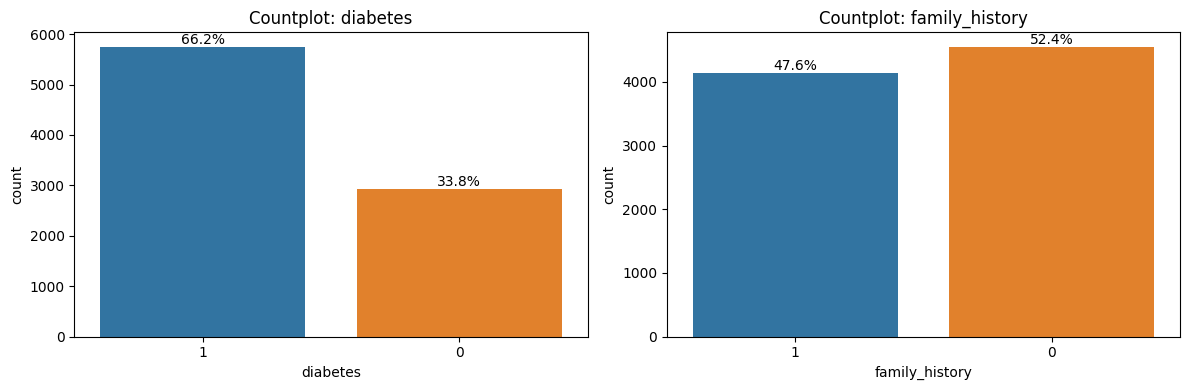

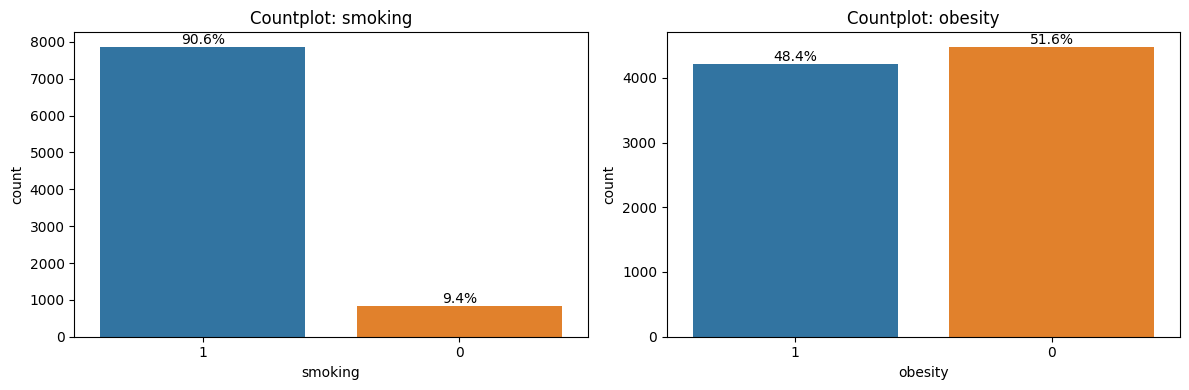

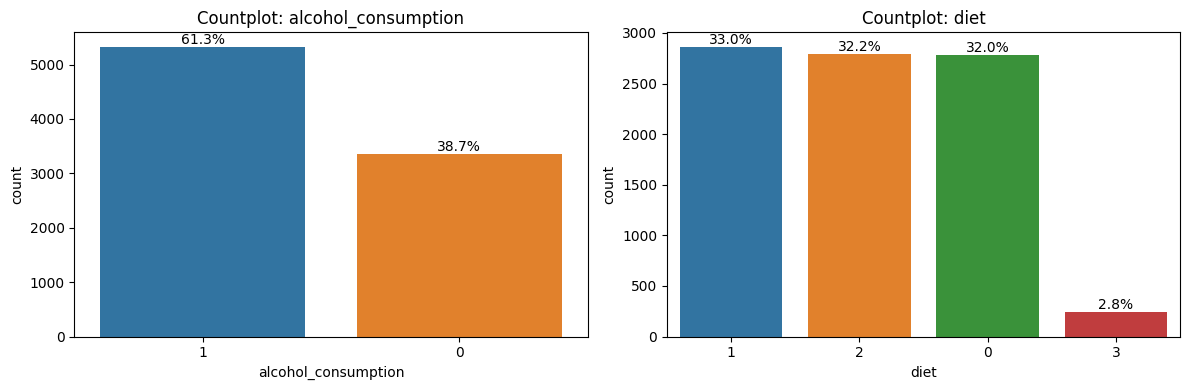

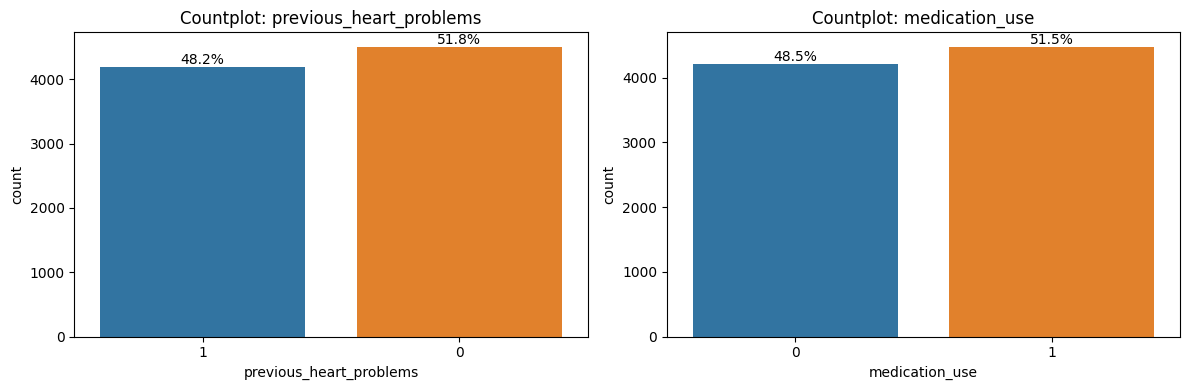

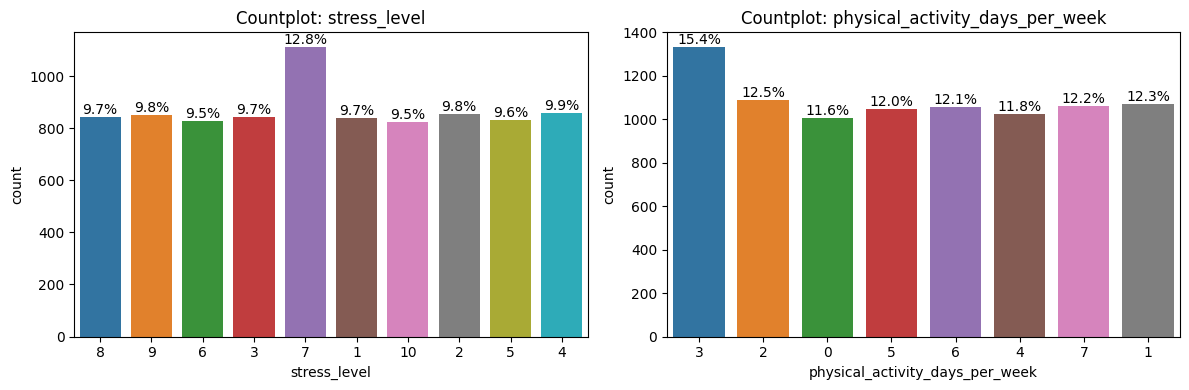

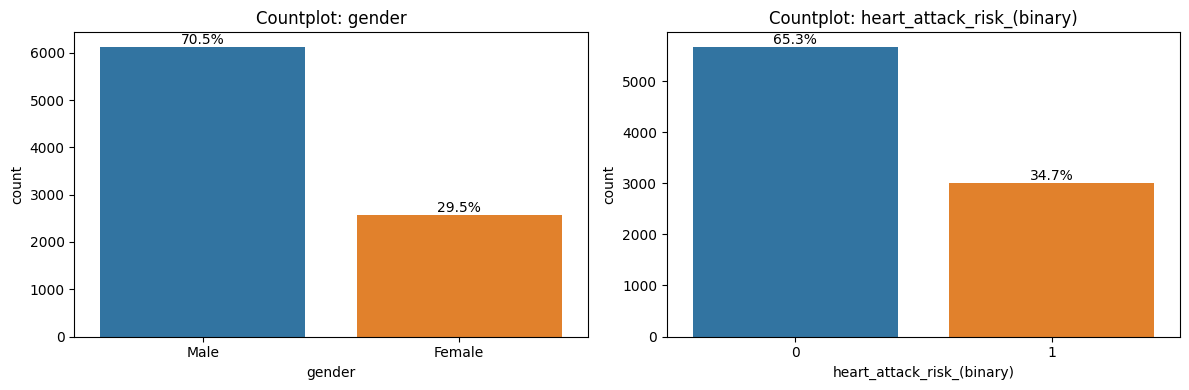

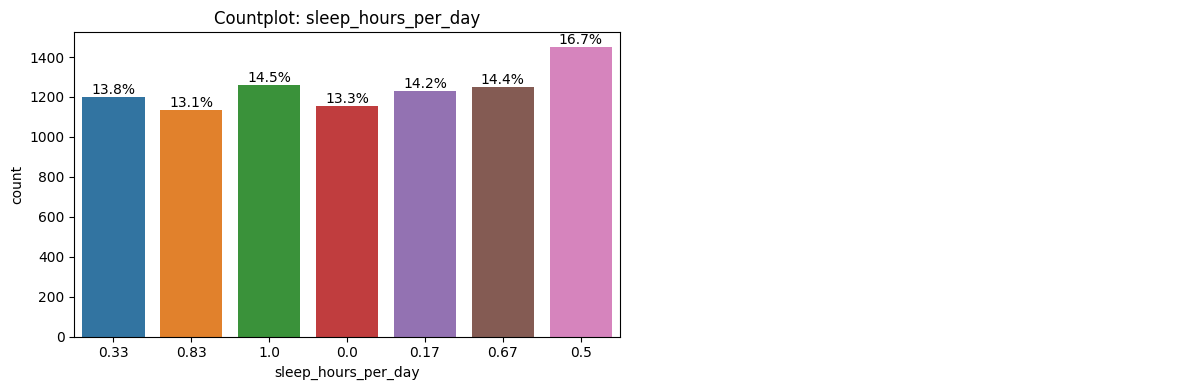

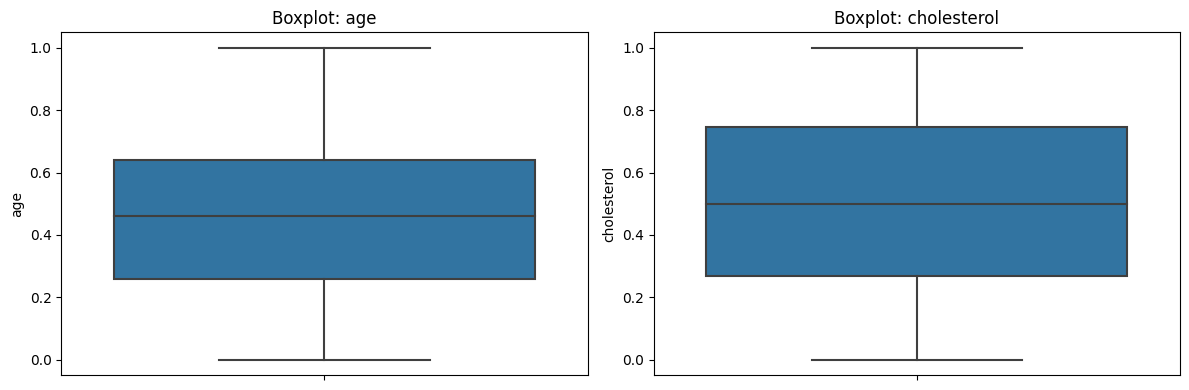

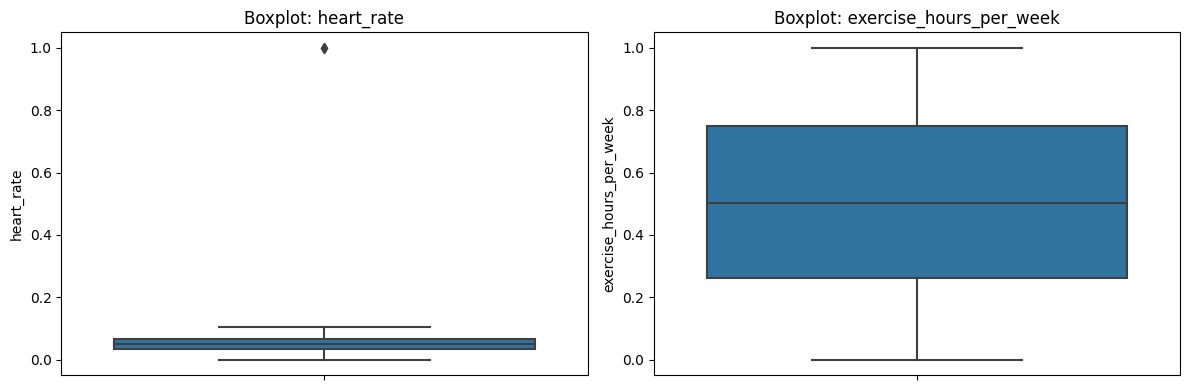

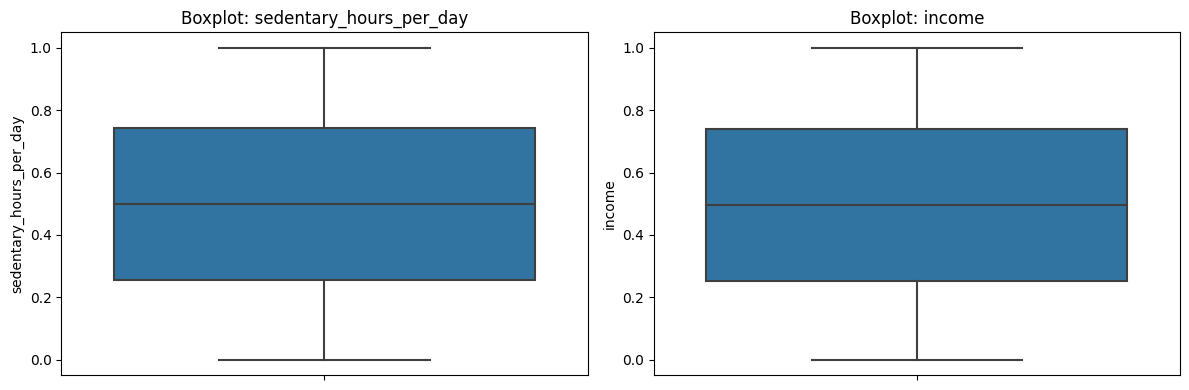

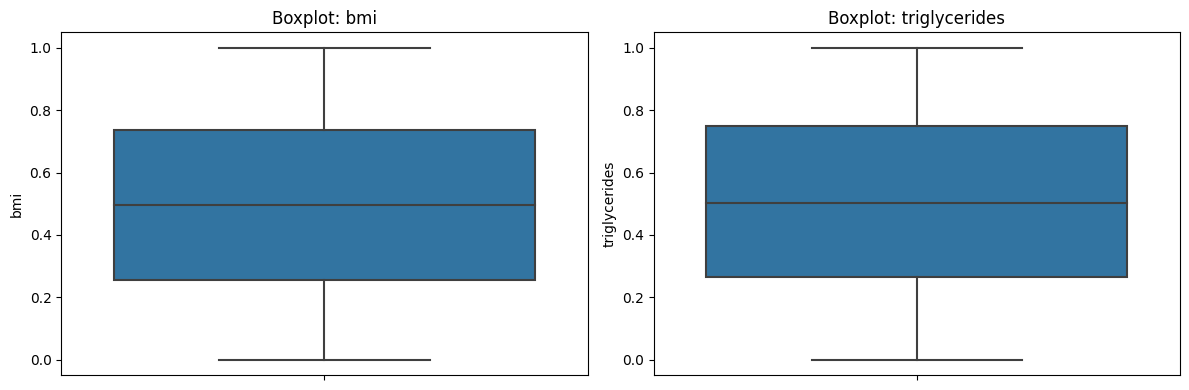

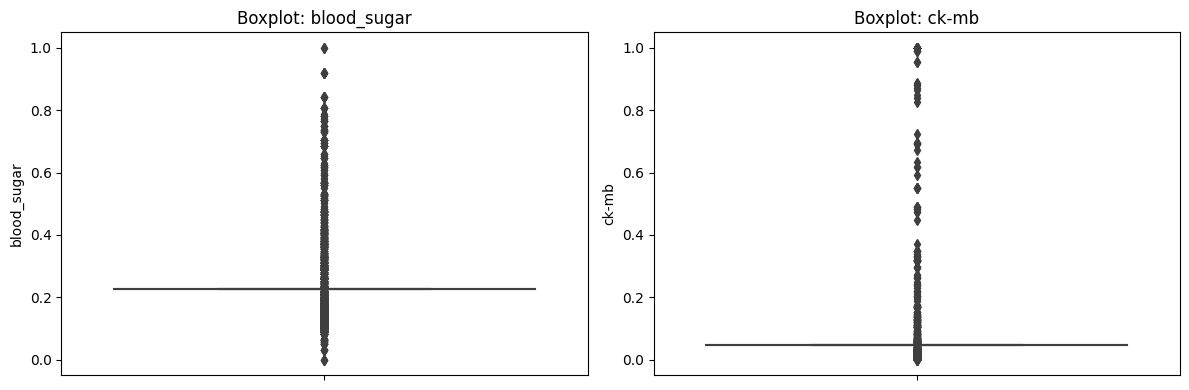

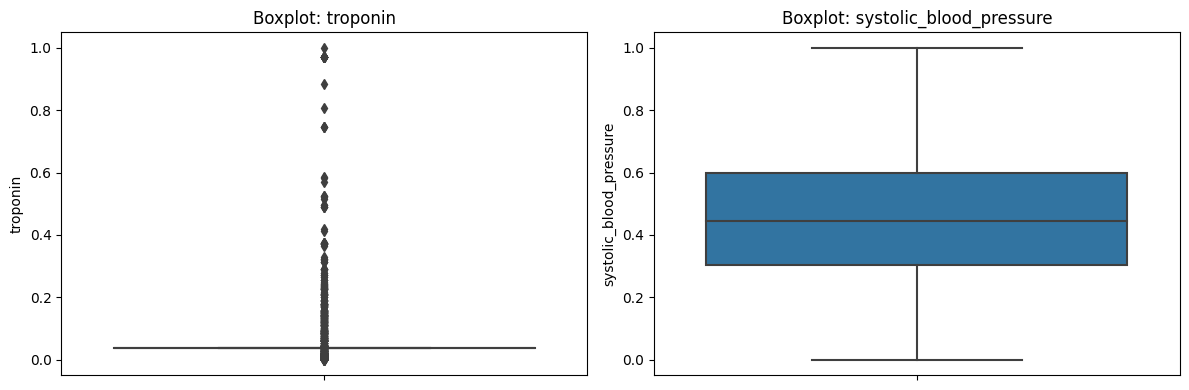

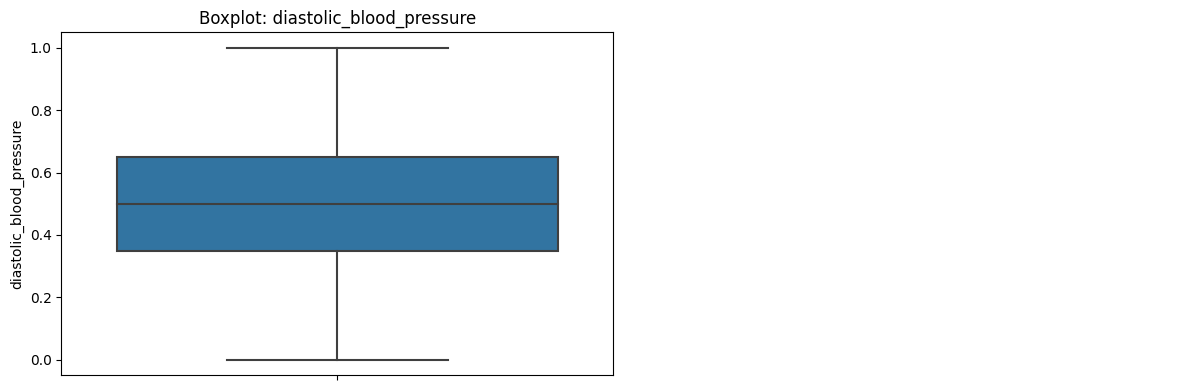

In [24]:
graphs(heart_train, discrete_cols, continuous_cols)

In [25]:
#проверяем выброс в признаке heart_rate
print(f"Количество строк с выбросами: {(heart_train['heart_rate'] > 0.8).sum()}")

Количество строк с выбросами: 2


In [26]:
#удалим строки с выбросами в heart_rate
heart_train.drop(heart_train[heart_train['heart_rate'] > 0.8].index, inplace=True)

In [27]:
#функция для графиков распределения непрерывных признаков

def continuous_graphs(df, continuous_cols, figsize=(12, 4)):
    for i in range(0, len(continuous_cols), 2):
        cols_pair = continuous_cols[i:i+2]
        fig, axes = plt.subplots(1, 2, figsize=figsize)

        for ax, col in zip(axes, cols_pair):
            sns.histplot(df[col], kde=True, ax=ax)
            ax.set_title(col)

        if len(cols_pair) == 1:
            axes[1].axis('off')

        plt.tight_layout()
        plt.show()

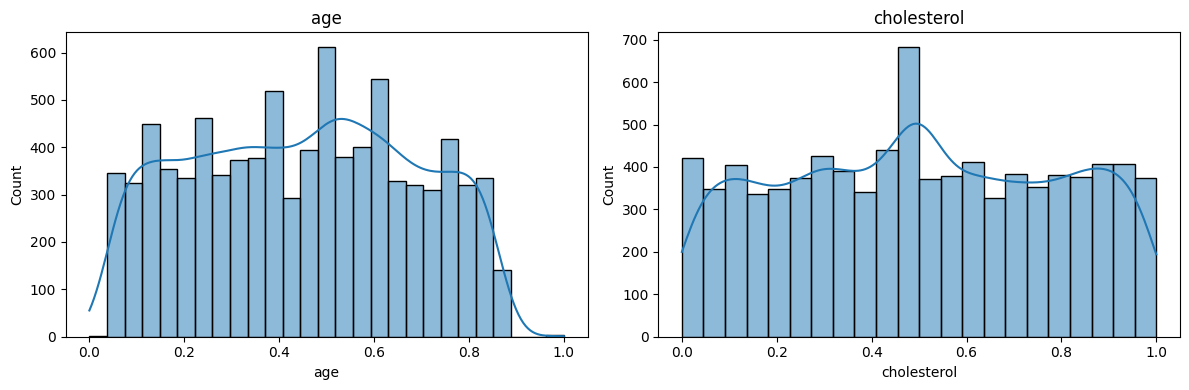

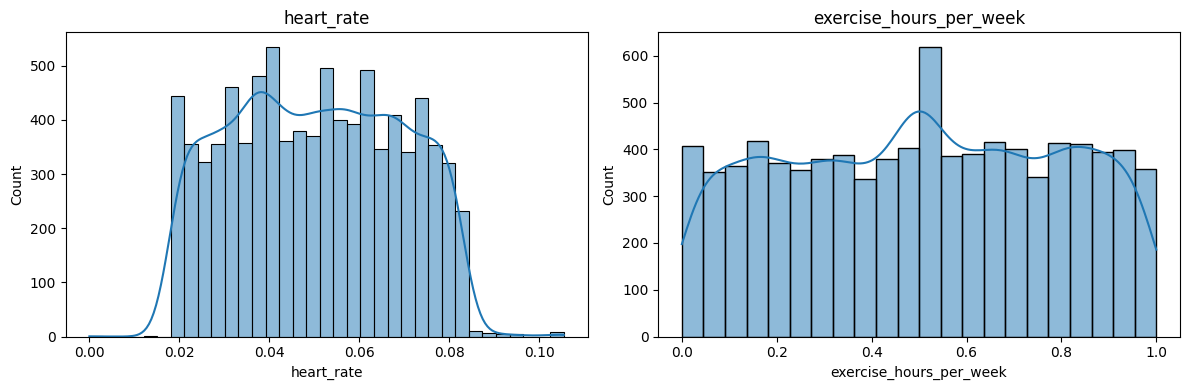

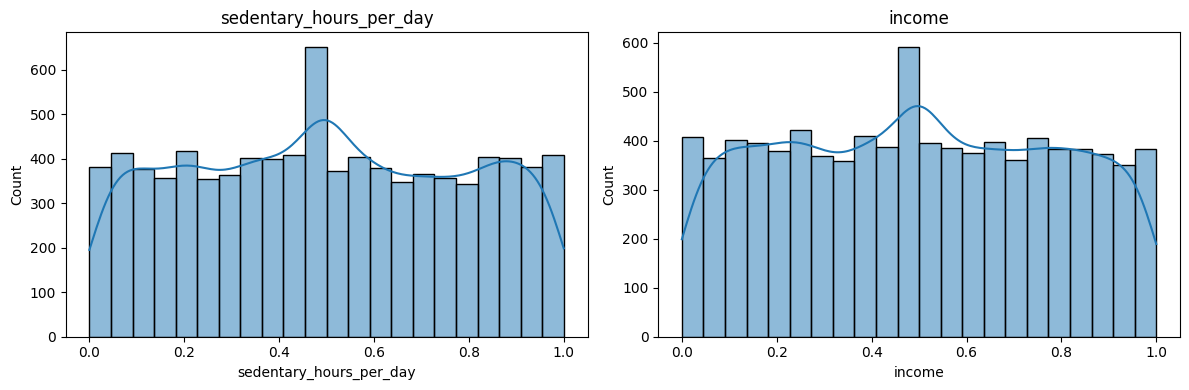

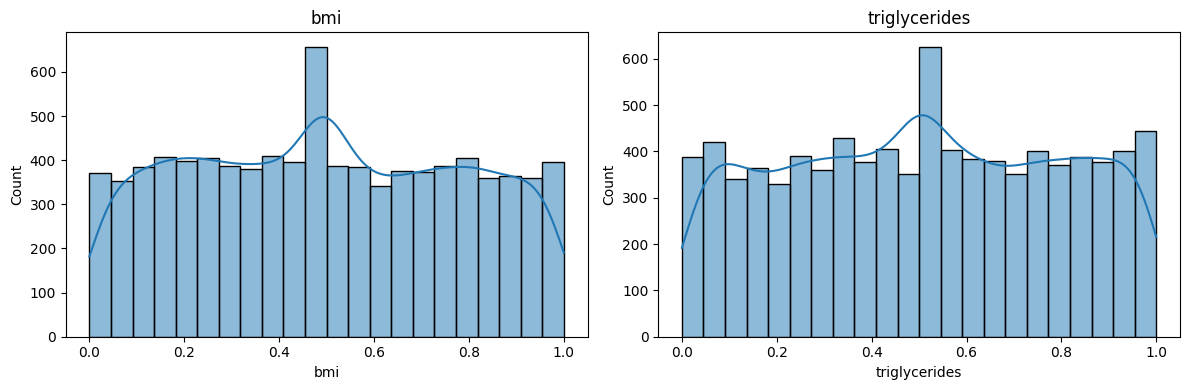

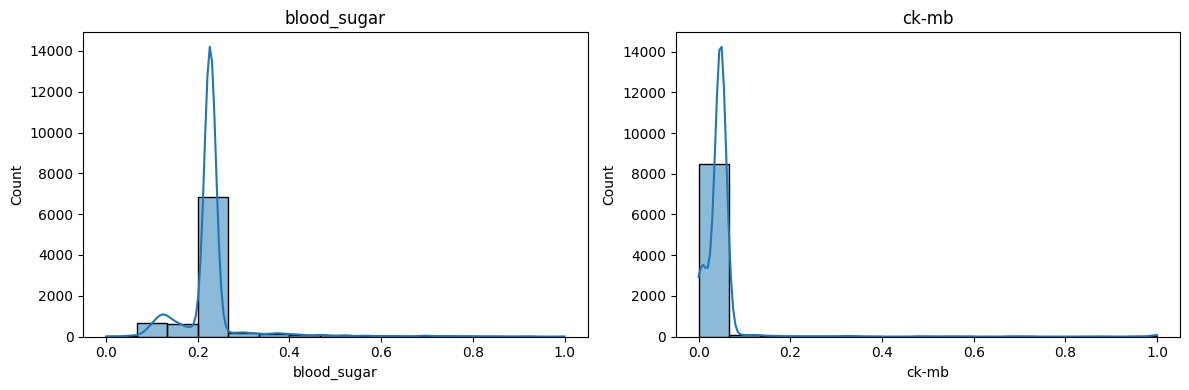

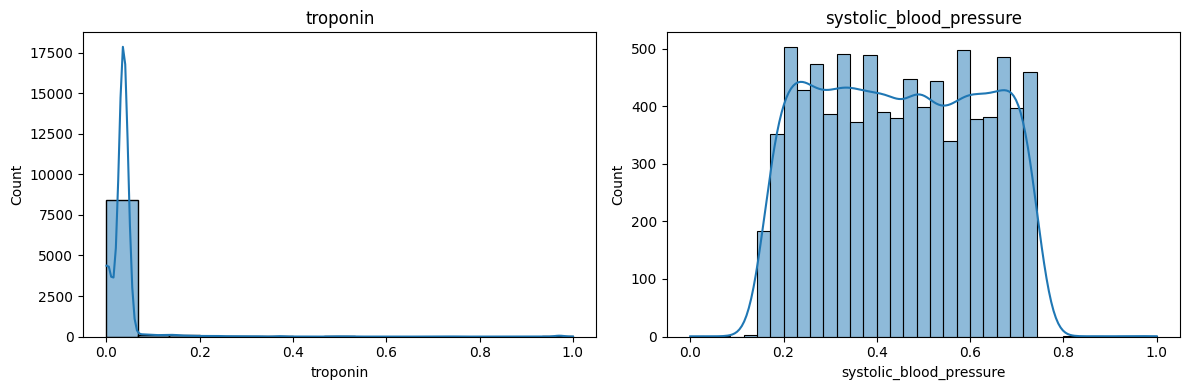

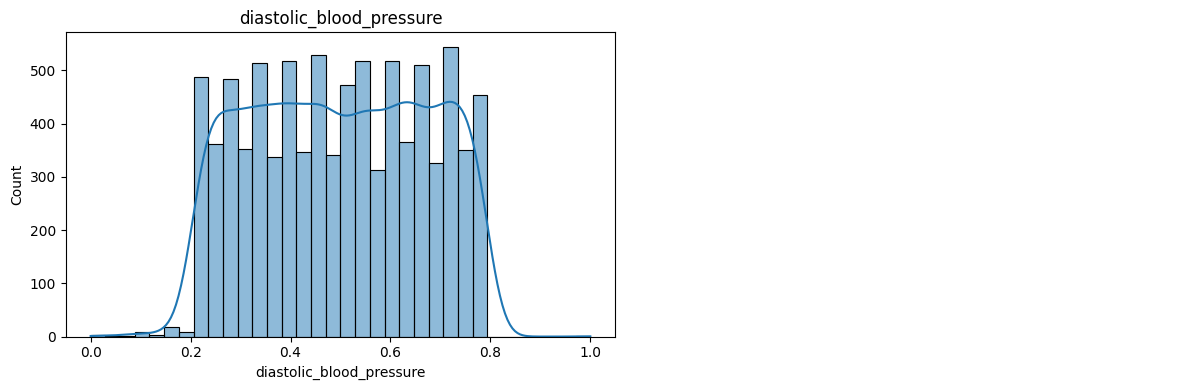

In [28]:
#посмотрим на распределение непрерывных признаков
continuous_graphs(heart_train, continuous_cols)

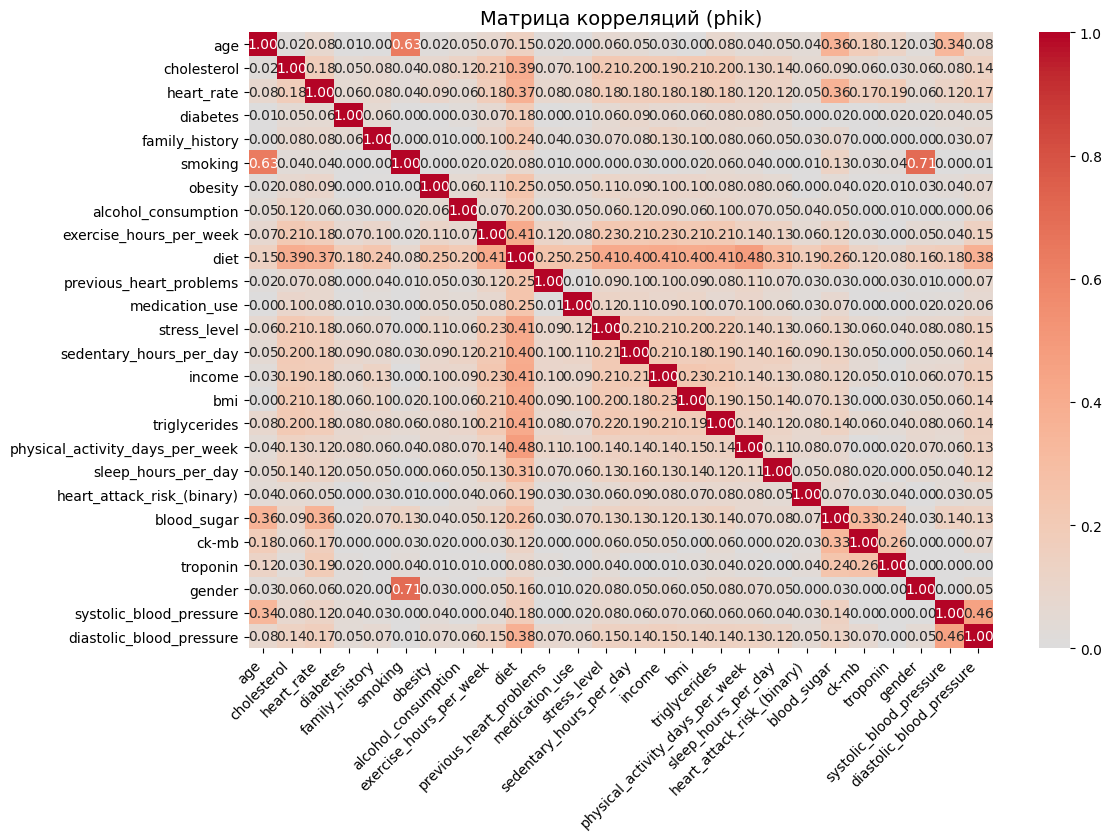

In [29]:
#строим матрицу корреляций

phik_matrix = heart_train.phik_matrix(interval_cols=continuous_cols)

#строим тепловую карту
plt.figure(figsize=(12, 8))
sns.heatmap(
    phik_matrix, 
    annot=True,
    fmt=".2f",
    cmap="coolwarm", 
    center=0
)
plt.title("Матрица корреляций (phik)", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.show()

In [30]:
#список признаков наиболее влияющих на целевой
phik_matrix['heart_attack_risk_(binary)'].sort_values(ascending=False).round(3)

heart_attack_risk_(binary)         1.000
diet                               0.186
sedentary_hours_per_day            0.087
income                             0.083
triglycerides                      0.081
physical_activity_days_per_week    0.076
bmi                                0.071
blood_sugar                        0.067
exercise_hours_per_week            0.062
stress_level                       0.061
cholesterol                        0.057
heart_rate                         0.054
diastolic_blood_pressure           0.053
sleep_hours_per_day                0.049
alcohol_consumption                0.045
age                                0.041
troponin                           0.035
systolic_blood_pressure            0.033
family_history                     0.031
previous_heart_problems            0.029
medication_use                     0.026
ck-mb                              0.025
smoking                            0.007
obesity                            0.000
diabetes        

In [31]:
#удалим признаки CK-MB и Troponin, т.к. это маркеры уже случившегося инфаркта (утечка целевого признака)
heart_train.drop(columns=['ck-mb', 'troponin'], inplace=True)

In [32]:
#удалим признаки gender, diabetes и obesity, т.к. с целевым признаком у них корреляция 0
heart_train.drop(columns=['gender', 'diabetes', 'obesity'], inplace=True)

**Промежуточный вывод:**

+ 70% пациентов - мужчины
+ 66% пациентов имеют диабет
+ у половины пациентов были родственники с болезнями сердца
+ 90% курят
+ у половины пациентов ожирение
+ большая часть (61%) принимают алкоголь
+ у половины пациентов и ранее наблюдались проблемы с сердцем
+ половина пациентов принимает лекарства
+ уровень стресса по шкале от 1 до 10 распределен равномерно (10% пациентов на каждом), у уровеня стресса 7 - 13%
+ физическая активность (дней в неделю) распределена равномерно, по 12% пациентов на каждом отрезке шкалы. Выделяется лишь 3 дня активности - 15% пациентов

Непрерывные признаки отмасштабированы, но мы можем оценить выбросы. Из всех признаков наиболее критичный выброс обнаружен в признаке "пульс", из 8000 строк только в двух значение составляет 1, тогда как все остальные значения лежат в диапазоне до 0.1. Было принято решение удалить данные строки.

Распределение непрерывных признаков:
1. Большинство признаков с равномерным распределением (age, cholesterol, sedentary_hours_per_day, income, bmi, triglycerides).
2. Есть признаки с выраженными пиками (blood_sugar, ck-mb, troponin, diastolic_blood_pressure, systolic_blood_pressure). Пики обозначают как норму при анализах у абсолютного большинства пациентов, так и возможную утечку данных.

Корреляционный анализ:
1. Мультиколлинеарность не выявлена.
2. Признаки с наибольшей корреляцией с целевым:
    - diet - 0.186
    - sedentary_hours_per_day - 0.087
    - мincome - 0.083
    - triglycerides - 0.081
    - physical_activity_days_per_week - 0.076
    - bmi - 0.071
    - blood_sugar - 0.067
    - exercise_hours_per_week - 0.062
    - stress_level - 0.061
    - cholesterol - 0.057
    - heart_rate - 0.054
    - diastolic_blood_pressure - 0.053
    - sleep_hours_per_day - 0.049
    - alcohol_consumption - 0.045
    - age - 0.041
    - troponin - 0.035
    - systolic_blood_pressure - 0.033
    - family_history - 0.031
3. Удалили признаки с 0 корреляцией с целевым: obesity и diabetes, т.к. они не повлияют на качество модели, но могут создавать шум.

Выявлены утечки целевого признака: маркеры уже случившегося инфаркта CK-MB и Troponin. Удалили их из датасета.
    

## Обучение модели

In [33]:
RANDOM_STATE = 42

In [34]:
#разделяем выборку на тренировочную, валидационную и тестовую

X_train, X_valid, y_train, y_valid = train_test_split(
    heart_train.drop(['heart_attack_risk_(binary)'], axis=1),
    heart_train['heart_attack_risk_(binary)'],
    test_size = 0.25, 
    random_state = RANDOM_STATE,
    stratify = heart_train['heart_attack_risk_(binary)'])

X_test = heart_test.copy()

In [35]:
#создаем пайплайн с моделью и трансформером

pipe = Pipeline(
    [
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [36]:
#создаем список со словарями гиперпараметров для разных моделей

param_grid = [
    #словарь для модели DecisionTreeClassifier
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5)
    },
    #словарь для модели KNeighborsClassifier
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5)
    },
    #словарь для модели LogisticRegression
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE,
                                      solver='liblinear',
                                      penalty='l1'
                                      )],
        'models__C': range(1, 5)
    },
    #словарь для модели SVC
    {
        'models': [SVC(random_state=RANDOM_STATE,
                       probability=True
                       )],
        'models__C': [0.1, 1, 10],
        'models__kernel': ['linear', 'rbf'],
        'models__gamma': ['scale', 'auto']
    },
    #словарь для модели CatBoost
    {
        'models': [CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)],
        'models__iterations': [200, 500, 800],
        'models__depth': [4, 6, 8],
        'models__learning_rate': [0.01, 0.03, 0.1],
        'models__l2_leaf_reg': [1, 3, 5, 7],
        'models__border_count': [32, 64, 128],
        'models__bagging_temperature': [0, 1, 5],
        'models__random_strength': [0, 1, 5], 
    }
]

In [37]:
#обучаем модели через поиск лучших параметров

randomized_search = RandomizedSearchCV(
    pipe, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)

print('Лучшая модель:', randomized_search.best_estimator_.named_steps['models'].__class__.__name__)
print('Метрика ROC-AUC лучшей модели на кросс-валидации:', randomized_search.best_score_.round(3))

Лучшая модель: CatBoostClassifier
Метрика ROC-AUC лучшей модели на кросс-валидации: 0.606


In [38]:
#проверяем модель на валидационной выборке

y_valid_pred = randomized_search.predict_proba(X_valid)[:, 1]
print(f'Метрика ROC-AUC на валидационной выборке: {(roc_auc_score(y_valid, y_valid_pred)).round(3)}')

Метрика ROC-AUC на валидационной выборке: 0.577


Вычисляем SHAP значения... (это может занять некоторое время)


  0%|          | 0/50 [00:00<?, ?it/s]

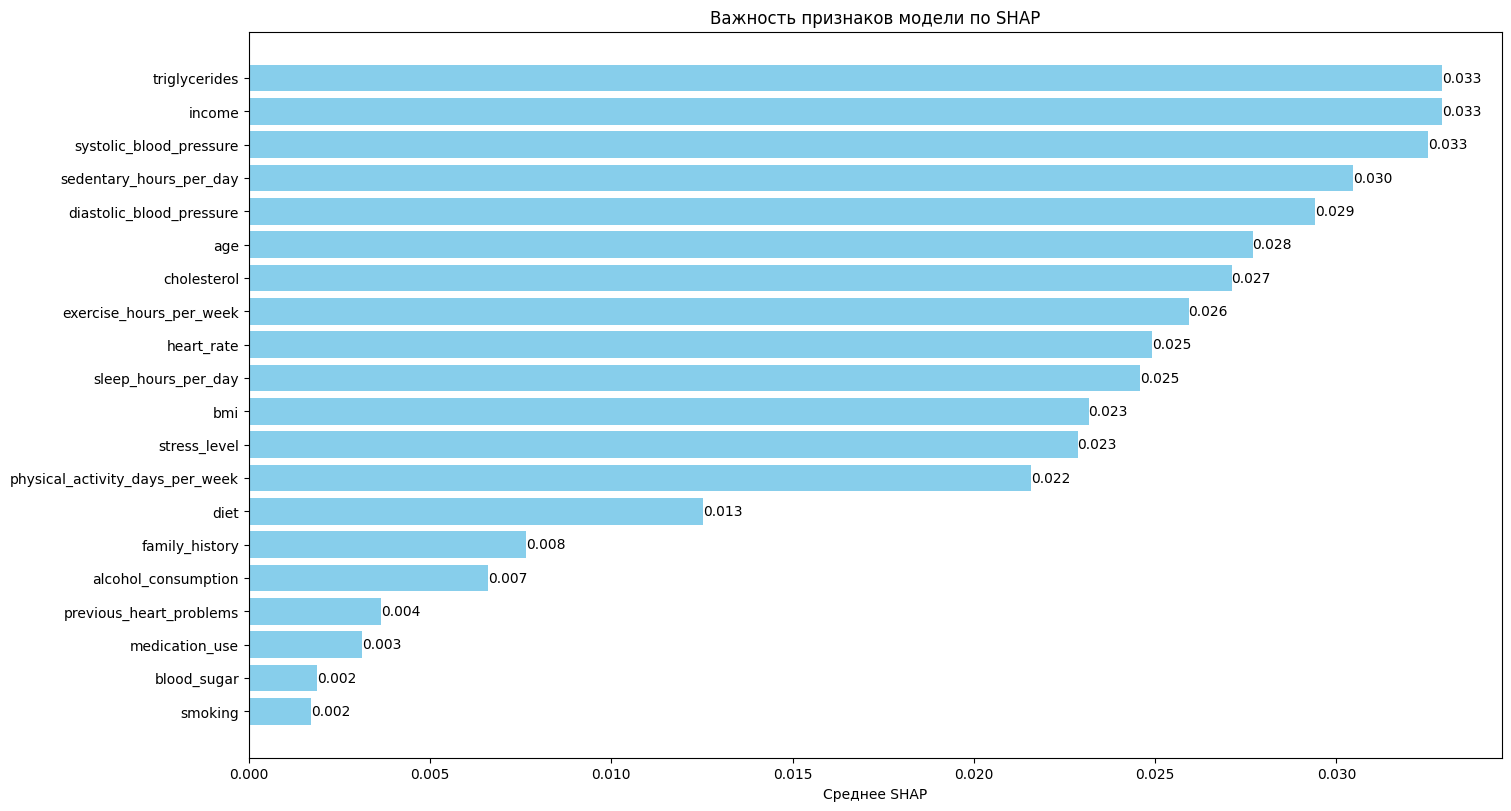

In [39]:
#построим диаграмму важности признаков SHAP

#берем лучшую модель
best_model = randomized_search.best_estimator_

#список с названиями колонок
feature_names = X_train.columns.tolist()

#берем подвыборки для ускорения расчёта SHAP (50 строк)
X_train_sample = resample(X_train, n_samples=50, random_state=RANDOM_STATE)
X_valid_sample = resample(X_valid, n_samples=50, random_state=RANDOM_STATE)

#функция предсказания
def predict_function(X):
    return best_model.predict(X)

#создаем объяснитель и вычисляем SHAP значения
print("Вычисляем SHAP значения... (это может занять некоторое время)")
explainer = shap.KernelExplainer(predict_function, X_train_sample)
shap_values = explainer.shap_values(X_valid_sample)

#средние абсолютные значения SHAP
shap_abs_mean = np.abs(shap_values).mean(axis=0)

#сортировка признаков по важности
indices = np.argsort(shap_abs_mean)[::-1]
shap_sorted = shap_abs_mean[indices]
features_sorted = [feature_names[i] for i in indices]

#график важности признаков
fig, ax = plt.subplots(figsize=(15, 8), constrained_layout=True)
bars = ax.barh(features_sorted, shap_sorted, color='skyblue')
ax.set_xlabel("Среднее SHAP")
ax.set_title("Важность признаков модели по SHAP")

#добавляем подписи значений над столбцами
for bar in bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2, f"{width:.3f}", va='center')

ax.invert_yaxis()
plt.show()

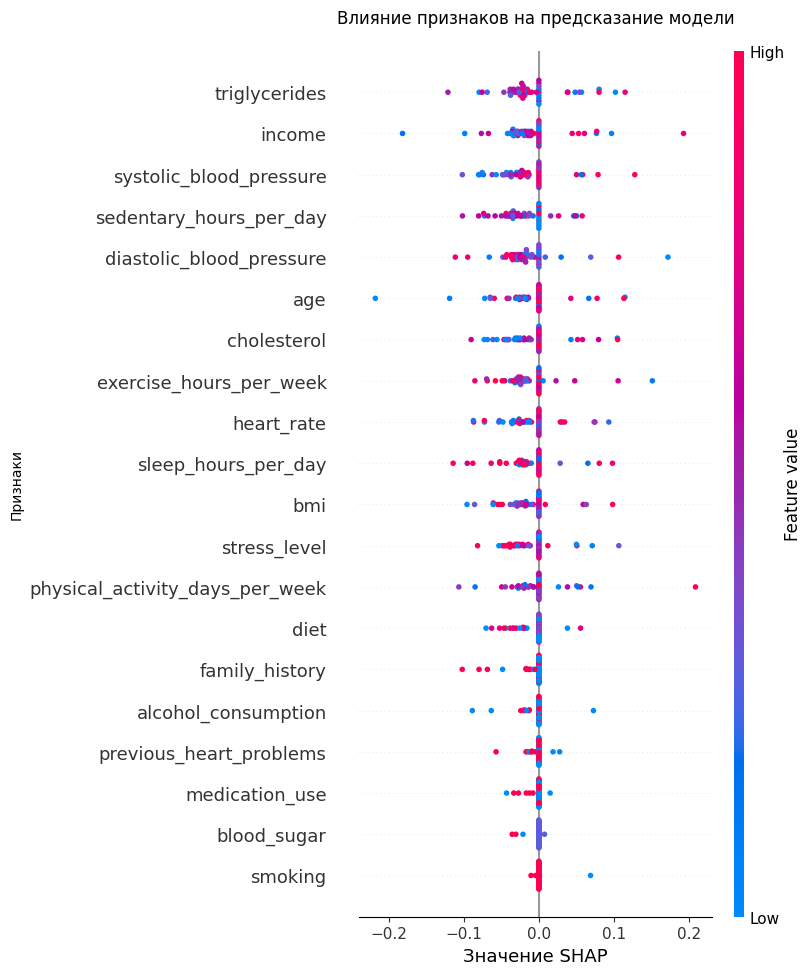

In [40]:
#смотрим как именно влияют признаки на целевой

shap.summary_plot(
    shap_values, 
    X_valid_sample, 
    feature_names=feature_names, 
    plot_type="dot", 
    show=False
)

plt.title("Влияние признаков на предсказание модели", pad=20)
plt.xlabel("Значение SHAP")
plt.ylabel("Признаки")
plt.show()

**Промежуточный вывод:** с помощью кросс-валидации подобрали гиперпараметры и нашли модель с лучшей метрикой.

- Лучшая модель - CatBoostClassifier
- Метрика ROC-AUC на кросс-валидации - 0.606
- Метрика ROC-AUC на валидационной выборке - 0.577

Выбрана метрика ROC-AUC, т.к. целевой признак несбалансирован.

Результат метрики ниже среднего, модель предсказывает сердечный приступ немногим лучше, чем подбрасывание монетки. Предположительно не хватает входных признаков с высокой корреляцией с целевым. Эксперименты с добавлением искусственных признаков не дали ощутимого прироста качества модели.

Наиболее важные признаки, влияющие на целевой в модели: systolic_blood_pressure, income, sedentary_hours_per_day, triglycerides. Как и в случае с корреляцией, влияют они слабо, и четкого разделения влияния на высокий или низкий шанс сердечного приступа у них нет, поэтому и не самая лучшая метрика качества предсказаний.

## Подготовка модели для приложения

In [41]:
#сохраняем пайплайн с моделью в отдельный файл
dump(best_model, 'model/model.joblib')

['model/model.joblib']

In [42]:
#проверяем, что модель сохранилась и работает

m = load("model/model.joblib")
m.predict(X_valid.head(5))

array([0, 0, 0, 0, 0], dtype=int64)

## Общий вывод

Мы разработали модель, которая предсказывает риск сердечного приступа у пациентов, а также создали приложение на базе Fast API, которое принимает csv с данными и выдает предсказания.

**Анализ данных**:
1. Получен дадасет с 8.6 тысячами строк
2. Дискретные признаки:
   + 70% пациентов - мужчины
   + 66% пациентов имеют диабет
   + У половины пациентов были родственники с болезнями сердца
   + 90% курят
   + У половины пациентов ожирение
   + Большая часть (61%) принимают алкоголь
   + У половины пациентов и ранее наблюдались проблемы с сердцем
   + Половина пациентов принимает лекарства
   + Уровень стресса по шкале от 1 до 10 распределен равномерно (10% пациентов на каждом), у уровеня стресса 7 - 13%
   + Физическая активность (дней в неделю) распределена равномерно, по 12% пациентов на каждом отрезке шкалы. Выделяется лишь 3 дня активности - 15% пациентов
3. Непрерывные признаки отмасштабированы, но мы можем оценить выбросы. Наиболее критичный выброс у признака "пульс" удален.
    + Большинство признаков с равномерным распределением (age, cholesterol, sedentary_hours_per_day, income, bmi, triglycerides).
    + Есть признаки с выраженными пиками (blood_sugar, ck-mb, troponin, diastolic_blood_pressure, systolic_blood_pressure). Пики обозначают как норму при анализах у абсолютного большинства пациентов, так и возможную утечку данных.
4. Корреляционный анализ:
   + Мультиколлинеарность не выявлена.
   + Признаки с наибольшей корреляцией с целевым:
      - diet - 0.186
      - sedentary_hours_per_day - 0.087
      - мincome - 0.083
      - triglycerides - 0.081
      - physical_activity_days_per_week - 0.076
      - bmi - 0.071
      - blood_sugar - 0.067
      - exercise_hours_per_week - 0.062
      - stress_level - 0.061
      - cholesterol - 0.057
      - heart_rate - 0.054
      - diastolic_blood_pressure - 0.053
      - sleep_hours_per_day - 0.049
      - alcohol_consumption - 0.045
      - age - 0.041
      - troponin - 0.035
      - systolic_blood_pressure - 0.033
      - family_history - 0.031
5. Удалили признаки с 0 корреляцией с целевым: obesity и diabetes, т.к. они не повлияют на качество модели, но могут создавать шум. Выявлены утечки целевого признака: маркеры уже случившегося инфаркта CK-MB и Troponin, удалили их из датасета.

**Модели машинного обучения:**
1. Мы обучили несколько моделей на кросс валидации, и с помощью метрики ROC-AUC выбрали лучшую:
   + Лучшая модель - CatBoostClassifier
   + Метрика ROC-AUC на кросс-валидации - 0.606
   + Метрика ROC-AUC на валидационной выборке - 0.577
2. Выбрана метрика ROC-AUC, т.к. целевой признак несбалансирован (65% без сердечного приступа).
3. Результат метрики ниже среднего, модель предсказывает сердечный приступ немногим лучше, чем подбрасывание монетки. Предположительно не хватает входных признаков с высокой корреляцией с целевым. Эксперименты с добавлением искусственных признаков не дали ощутимого прироста качества модели.
4. Наиболее важные признаки, влияющие на целевой в модели: systolic_blood_pressure, income, sedentary_hours_per_day, triglycerides. Как и в случае с корреляцией, влияют они слабо, и четкого разделения влияния на высокий или низкий шанс сердечного приступа у них нет, поэтому и не самая лучшая метрика качества предсказаний.

**Приложение на FastAPI:**
1. Разработали структуру проекта:
   
   ```text
      heart-attack-prediction/
      │
      ├── app/
      │   ├── main.py              #FastAPI приложение (роуты)
      │   ├── model_service.py     #загрузка модели, предобработка, получение предсказаний
      │   ├── schemas.py           #pydantic-схема (для json запроса)
      │   └── templates/
      │       └── upload.html      #HTML-интерфейс
      │
      ├── model/
      │   └── model.joblib         #обученная модель (CatBoost)
      │
      ├── predictions/
      │   └── predictions.csv      #результаты предсказаний (создается автоматически)
      │
      ├── heart_attack.ipynb       #анализ данных, исследование, поиск лучшей модели
      │
      ├── requirements.txt         #зависимости проекта
      ├── README.md                #описание проекта
      └── .gitignore
2. Подготовили модель к использованию:
   + Сохранили лучшую модель (CatBoost) в отдельный файл model/model.joblib.
   + Обеспечили возможность загрузки модели в отдельном классе ModelService с методами предобработки данных (как при обучении) и получения предсказаний.
3. Создали FastAPI-приложение (main.py):
   + Создан объект app = FastAPI()
   + При старте сервера загружается объект ModelService с моделью
   + Реализованы эндпоинты:
      - GET / - отображение html страницы
      - POST /upload - загрузка CSV и получение предсказаний
      - POST /upload/path - загрузка CSV через json запрос
      - GET /download - скачивание CSV с результатами
4. Создали веб-интерфейс:
   + Добавлен HTML-файл upload.html с формой для загрузки и скачивания CSV, выводом таблицы предсказаний.
   + Интерфейс интегрирован с FastAPI через модуль Jinja2Templates.
   